In [1]:
import datetime

date = datetime.datetime.now()
print(f'Today is Happy{date: %A, %d, %m, %Y}.', '\n')

import os
from glob import glob
import math
import random 
import argparse                                                                                                                          
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.lines import Line2D
import itertools
import scipy as sp
from scipy import stats
from scipy.stats import norm, wilcoxon, linregress 
import scipy.stats as sp
from statannot import add_stat_annotation
from PIL import Image
import cv2 as cv
import torch

sns.set_context("paper", rc={"axes.titlesize":16,"axes.labelsize":14, "xtick.labelsize":12, "ytick.labelsize":12})   
sns.set_style('whitegrid', rc={'font.family': 'serif', 'font.serif': 'Times New Roman'})

Today is Happy Tuesday, 25, 10, 2022. 



c:\ProgramData\Anaconda3\envs\python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Button

In [11]:
date = '2022-10-25'
time = '17-28-53'
windows = True # True for Windows, False for MAC

stim_type = 'elec' # 'opt' or 'elec'
top1 = True # True for top1, False if top2
env_type = 'CartPole-v1'

if windows:
    data_dir = 'C:\\Users\\Na Min An\\Desktop\\Development\\Project\\code\\data'
    outputs_dir = f'C:\\Users\\Na Min An\\Desktop\\Development\\Project\\code\\outputs\\{date}' #\\{time}\\outputs'
    slash = '\\'
else:
    data_dir = '/Users/naminan/Development/Project/code/data'
    outputs_dir = f'/Users/naminan/Development/Project/code/outputs' #/{date}/{time}/outputs'
    slash = '/'

label_path = os.path.join(data_dir, '211105_QAs_for_Set0_CNN_SVC_4classes_partial.csv')
pred_dir =  os.path.join(os.path.join(data_dir, 'Human_Expert'), '211202')

# recursive method
model_state_dict_files = glob(f'{outputs_dir}{slash}**{slash}*.pth', recursive=True)
train_returns_files = glob(f'{outputs_dir}{slash}**{slash}TrainReturns_*.csv', recursive=True)
test_returns_files = glob(f'{outputs_dir}{slash}**{slash}TestReturns_*.csv', recursive=True)

assert os.path.exists(label_path)
assert os.path.exists(pred_dir)

assert len(model_state_dict_files) != 0
assert len(train_returns_files) != 0
assert len(test_returns_files) != 0

### Human data

In [150]:
if stim_type == 'opt':
  sel_ppl = list(range(300, 309)) + list(range(400, 408)) + [611] # 18 subjects
elif stim_type == 'elec': 
  # sel_ppl = [499, 500, 502] + list(range(504, 509)) + list(range(602, 606)) + list(range(608, 612)) # 16 subjects (no min & max)
  sel_ppl = [499, 500, 502] + list(range(503, 509)) + list(range(602, 607)) + list(range(608, 612)) # 18 subjects

human_df = pd.DataFrame()
n = 9
for i in range(1, 80*n+1, 80):
    try:
      j = i+79 
      temp_df = pd.read_csv(os.path.join(pred_dir, f'main_test({i}_{j}).csv'))
      if i == 1:
        pass
      else:
        temp_df = temp_df.rename(columns = {'유저식별아이디':'useless', 'MC구분':'useless', '성별':'useless', '나이':'useless', '학력':'useless'})
      human_df = pd.concat([human_df, temp_df], axis=1)
    except:
      print(i)

human_df = human_df[human_df['유저식별아이디'].isin(sel_ppl)]
orig_human_df = human_df
human_df = human_df.fillna(0)

sel_col = []
for j in range(1, 80*n+1):
    if top1:
      temp_str = f'선택_A_{j}'
      sel_col.append(temp_str)
    else:
      temp_str1 = f'선택_A_{j}'
      temp_str2 = f'선택_B_{j}'
      sel_col.append(temp_str1)
      sel_col.append(temp_str2)

human_df = human_df[sel_col]
human_df.index = sel_ppl 

if top1:
  human_df.columns = list(range(80*n))
else:
  human_df.columns = list(range(2*80*n))

question_df = pd.read_csv(label_path)

if top1:
  human_df.columns = question_df['Answer']
else:
  human_df.columns = [ans for ans in question_df['Answer'] for _ in (0, 1)]

processed_human_df = human_df.copy()
for (j, ans_file) in enumerate(processed_human_df.columns):
    face, pix, gs, par = ans_file.split('.')[0].split('_')
    act_face = int(face)
    for i in range(processed_human_df.shape[0]):
        pred_face = int(processed_human_df.iloc[i, j])
        if act_face == pred_face:
            processed_human_df.iloc[i, j] = 1.0
        else:
            processed_human_df.iloc[i, j] = 0.0

if not top1:
  processed_human_df = processed_human_df.iloc[:, 0:1440:2] + processed_human_df.iloc[:, 1:1440:2]

processed_human_df_T = processed_human_df.transpose()
face_lst, pix_lst, gs_lst, par_lst, exp_lst = [], [], [], [], []
for (i, ans_file) in enumerate(processed_human_df_T.index):
  face, pix, gs, par = ans_file.split('.')[0].split('_')
  face_lst.append(face)
  pix_lst.append(pix)
  gs_lst.append(gs)
  par_lst.append(par)
  exp_lst.append(par.split('C')[0].split('E')[-1])
processed_human_df_T['Face'] = face_lst
processed_human_df_T['PIX'] = pix_lst
processed_human_df_T['GS'] = gs_lst
processed_human_df_T['Par'] = par_lst
processed_human_df_T['Exp'] = exp_lst
processed_human_df_T['Mean'] = processed_human_df_T[sel_ppl].mean(axis=1)
processed_human_df_T['Mode'] = processed_human_df_T[sel_ppl].mode(axis=1)[0]

setorder_lst = [n for n in range(9)]*80
setorder_lst.sort()
processed_human_df_T['Set'] = setorder_lst

imp_par_lst = []
for i in range(processed_human_df_T.shape[0]):
  pix = processed_human_df_T['PIX'][i]
  gs = processed_human_df_T['GS'][i]
  exp = processed_human_df_T['Exp'][i]
  imp_par = f'{pix}_{gs}_{exp}' # {gs}
  imp_par_lst.append(imp_par)
processed_human_df_T['ImpPar'] = imp_par_lst

processed_human_df_T

,499,500,502,503,504,505,506,507,508,602,...,611,Face,PIX,GS,Par,Exp,Mean,Mode,Set,ImpPar
Answer,,,,,,,,,,,,,,,,,,,,,
19070311_16PIX_8GS_S001L1E03C7.jpg,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,19070311,16PIX,8GS,S001L1E03C7,03,0.166667,0.0,0,16PIX_8GS_03
19080133_32PIX_4GS_S001L1E03C7.jpg,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,19080133,32PIX,4GS,S001L1E03C7,03,0.500000,0.0,0,32PIX_4GS_03
19090222_32PIX_8GS_S001L1E01C4.jpg,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,19090222,32PIX,8GS,S001L1E01C4,01,0.500000,0.0,0,32PIX_8GS_01
19090631_16PIX_2GS_S001L1E03C7.jpg,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,19090631,16PIX,2GS,S001L1E03C7,03,0.555556,1.0,0,16PIX_2GS_03
19072221_32PIX_2GS_S001L1E01C4.jpg,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,19072221,32PIX,2GS,S001L1E01C4,01,0.222222,0.0,0,32PIX_2GS_01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19072221_16PIX_8GS_S001L1E01C7.jpg,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,19072221,16PIX,8GS,S001L1E01C7,01,0.500000,0.0,8,16PIX_8GS_01
19082131_16PIX_2GS_S001L1E01C7.jpg,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,19082131,16PIX,2GS,S001L1E01C7,01,0.277778,0.0,8,16PIX_2GS_01
19092521_32PIX_4GS_S001L1E01C7.jpg,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,19092521,32PIX,4GS,S001L1E01C7,01,0.833333,1.0,8,32PIX_4GS_01


### Graphs

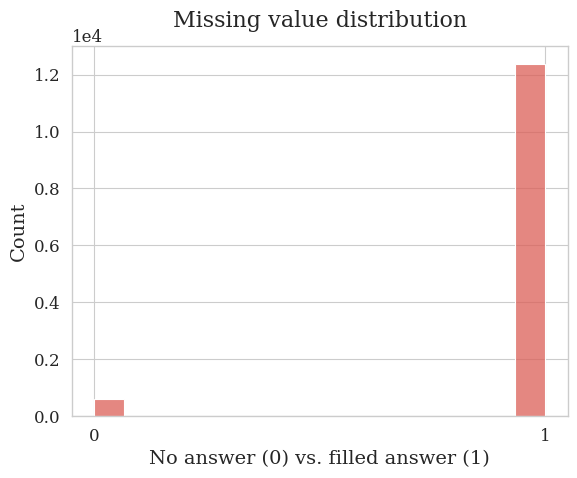

In [19]:
# Check nan values (x-axis: ID #, 0 means there was no answer)
bin_arr = np.where(human_df.values > 0.0, 1.0, 0.0).flatten()
sns.histplot(bin_arr, color=sns.color_palette('hls', 8)[0])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 4))
plt.xticks(range(0, 2))
plt.xlabel('No answer (0) vs. filled answer (1)')
plt.title('Missing value distribution', y=1.03)
plt.show()

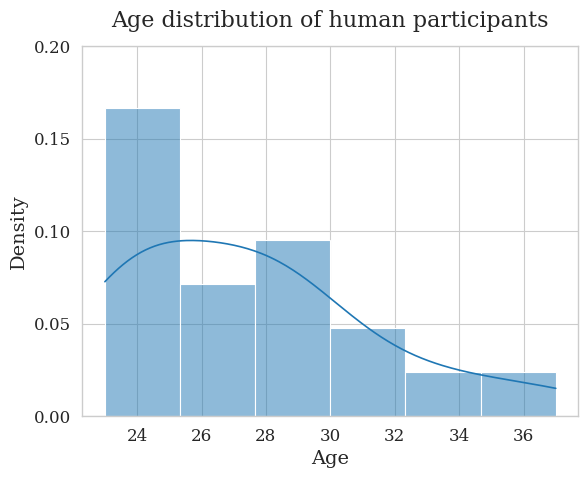

In [20]:
# Check age density 
sns.histplot(data=orig_human_df['나이'], stat='density', kde=True)
plt.yticks(np.arange(0.0, 0.21, 0.05))
plt.xlabel('Age')
plt.title('Age distribution of human participants', y=1.03)
plt.show()

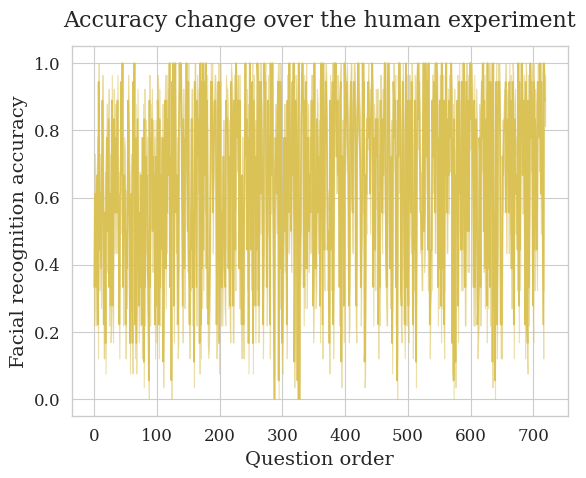

In [4]:
# Draw accuracy values per set order
x = range(processed_human_df.shape[-1])
y_mean, y_stderr = processed_human_df.mean(axis=0), processed_human_df.std(axis=0) / math.sqrt(processed_human_df.shape[0])
sns.lineplot(x=x, y=y_mean, color=sns.color_palette('hls', 8)[1])
plt.fill_between(x=x, y1=y_mean - y_stderr, y2=y_mean + y_stderr, color=sns.color_palette('hls', 8)[1], alpha=0.5)
plt.xlabel('Question order')
plt.ylabel('Facial recognition accuracy')
plt.title('Accuracy change over the human experiment', y=1.03)
plt.show()

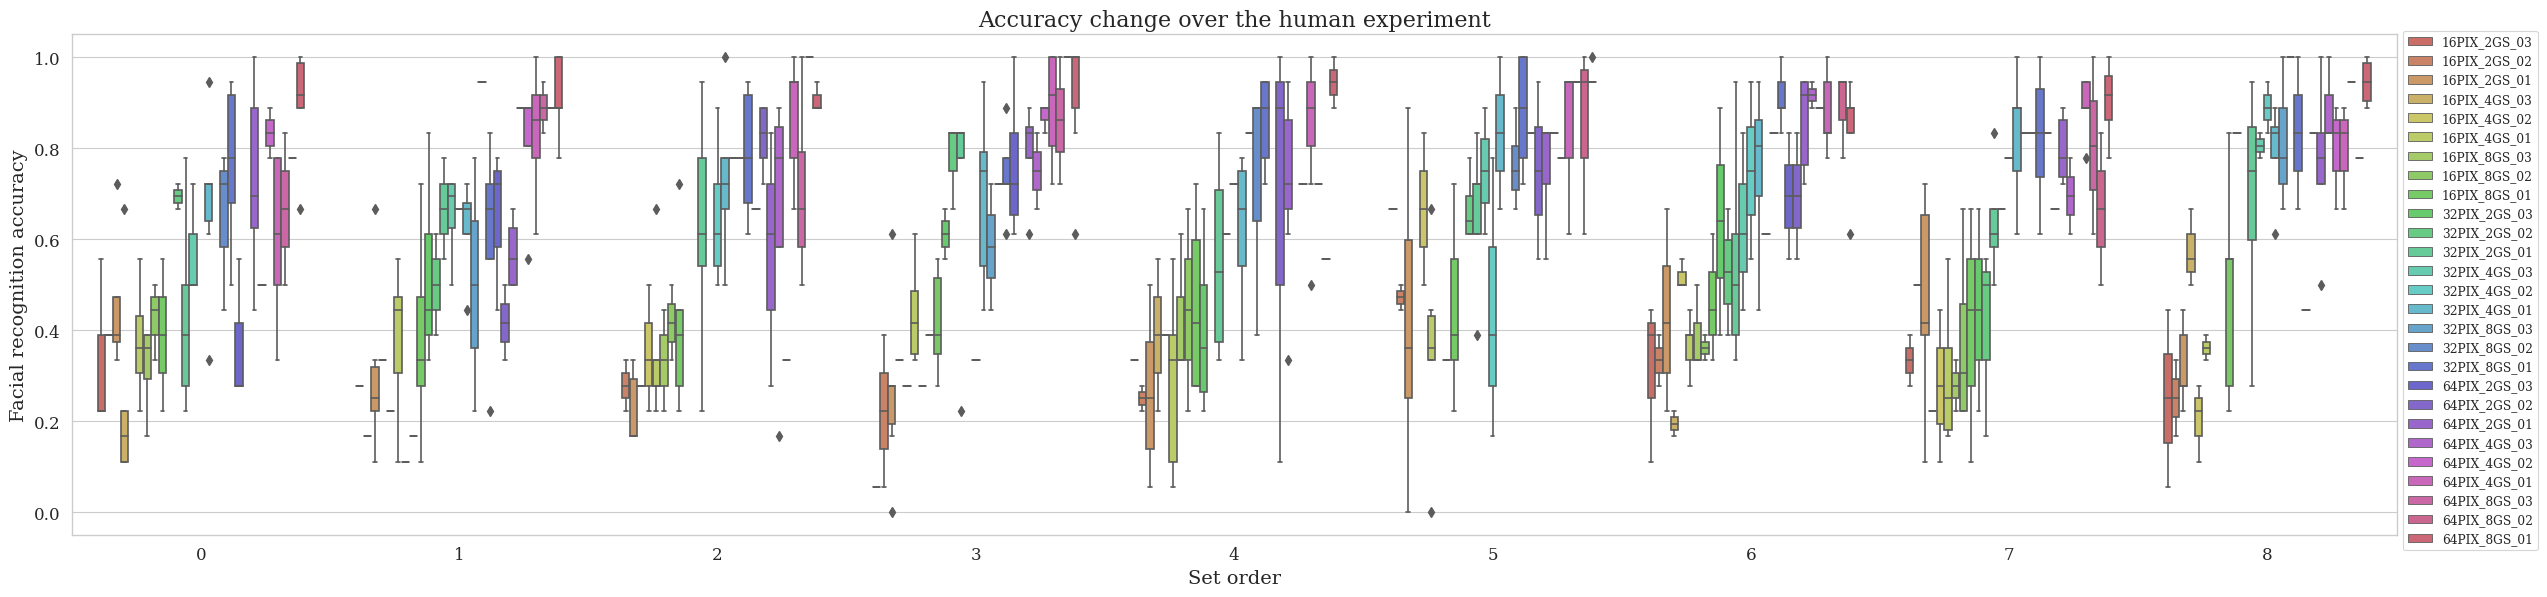

In [151]:
# Draw accuracy values per set order (with hues)
hue_order = ['16PIX_2GS', '16PIX_4GS', '16PIX_8GS',
             '32PIX_2GS', '32PIX_4GS', '32PIX_8GS',
             '64PIX_2GS', '64PIX_4GS', '64PIX_8GS']
hue_order = ['16PIX_03', '16PIX_02', '16PIX_01',
             '32PIX_03', '32PIX_02', '32PIX_01',
             '64PIX_03', '64PIX_02', '64PIX_01']
hue_order = ['16PIX_2GS_03', '16PIX_2GS_02', '16PIX_2GS_01',
             '16PIX_4GS_03', '16PIX_4GS_02', '16PIX_4GS_01',
             '16PIX_8GS_03', '16PIX_8GS_02', '16PIX_8GS_01',
             '32PIX_2GS_03', '32PIX_2GS_02', '32PIX_2GS_01',
             '32PIX_4GS_03', '32PIX_4GS_02', '32PIX_4GS_01',
             '32PIX_8GS_03', '32PIX_8GS_02', '32PIX_8GS_01',
             '64PIX_2GS_03', '64PIX_2GS_02', '64PIX_2GS_01',
             '64PIX_4GS_03', '64PIX_4GS_02', '64PIX_4GS_01',
             '64PIX_8GS_03', '64PIX_8GS_02', '64PIX_8GS_01']

plt.figure(figsize=(30, 6.5))
sns.boxplot(x='Set', y='Mean', hue='ImpPar', data=processed_human_df_T, palette=sns.color_palette("hls", 27),
            hue_order=hue_order)
plt.xlabel('Set order')
plt.ylabel('Facial recognition accuracy')
plt.title('Accuracy change over the human experiment', y=1)
plt.legend(bbox_to_anchor=(1, 1.02))
plt.show()

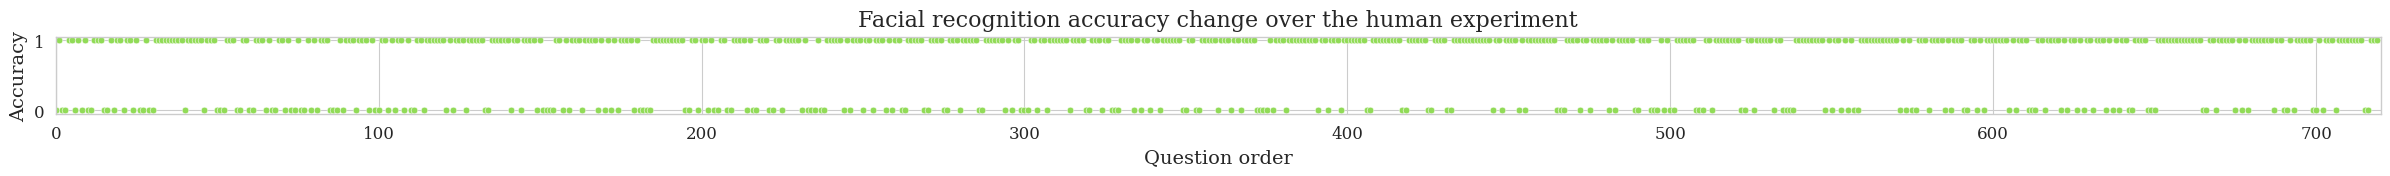

Ratio of 0's:  0.32
Ratio of 1's:  0.68


In [22]:
# Draw accuracy values per set order
plt.figure(figsize=(30, 1))
x = range(processed_human_df.shape[-1])
y_mode = processed_human_df.mode(axis=0).iloc[0, :]
sns.scatterplot(x=x, y=y_mode, color=sns.color_palette('hls', 8)[2])
plt.xlim([0, 720])
plt.xlabel('Question order')
plt.ylabel('Accuracy')
plt.title('Facial recognition accuracy change over the human experiment', y=1.03)
plt.show()

for i in range(2):
    count = pd.Series.value_counts(y_mode)[i]
    tot_count = pd.Series.count(y_mode)
    ratio = count / tot_count
    print(f"Ratio of {i}'s: {ratio : .2f}")

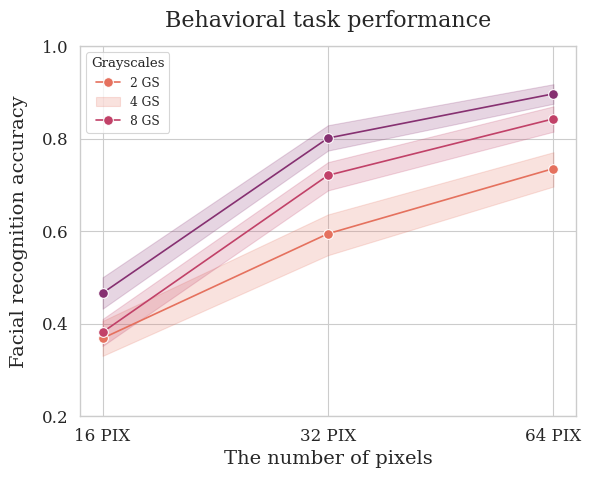

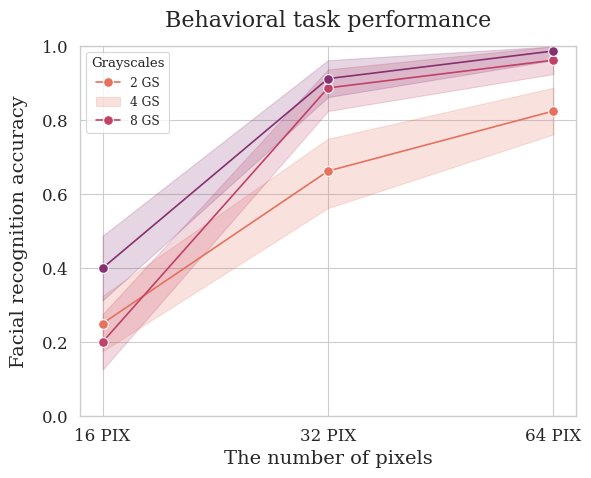

In [7]:
# Draw accuracy plots based on PIX & GS
processed_human_df_T = processed_human_df_T.sort_values(by=['PIX', 'GS'])

sns.lineplot(x='PIX', y='Mean', data=processed_human_df_T, hue='GS', err_style='band', ci=90, palette=sns.color_palette('flare', 3), legend=True, marker='o', markersize=7)
plt.ylim([0.2, 1])
plt.xticks(np.arange(3), labels=['16 PIX', '32 PIX', '64 PIX'])
plt.yticks(np.arange(0.2, 1.1, 0.2))
plt.xlabel('The number of pixels')
plt.ylabel('Facial recognition accuracy', labelpad=10)
plt.title('Behavioral task performance', y=1.03)
plt.legend(title='Grayscales', labels=['2 GS', '4 GS', '8 GS'])
plt.show()

sns.lineplot(x='PIX', y='Mode', data=processed_human_df_T, hue='GS', err_style='band', ci=90, palette=sns.color_palette('flare', 3), legend=True, marker='o', markersize=7)
plt.ylim([0, 1])
plt.xticks(np.arange(3), labels=['16 PIX', '32 PIX', '64 PIX'])
plt.yticks(np.arange(0.0, 1.1, 0.2))
plt.xlabel('The number of pixels')
plt.ylabel('Facial recognition accuracy', labelpad=10)
plt.title('Behavioral task performance', y=1.03)
plt.legend(title='Grayscales', labels=['2 GS', '4 GS', '8 GS'])
plt.show()


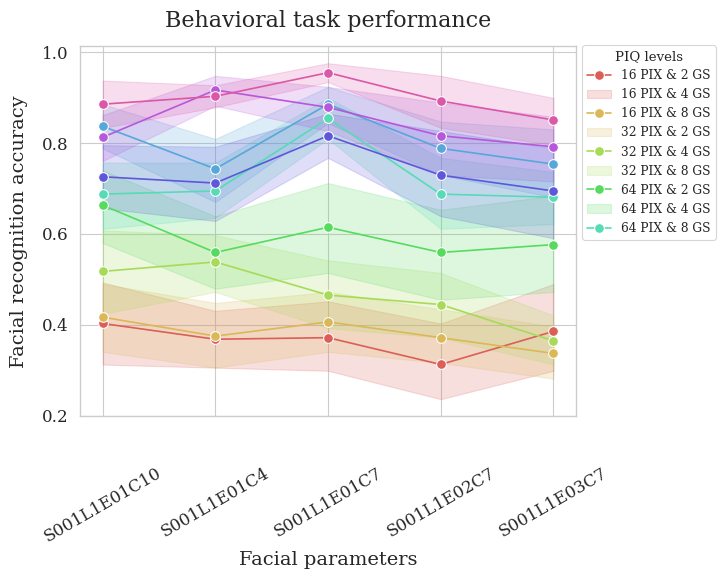

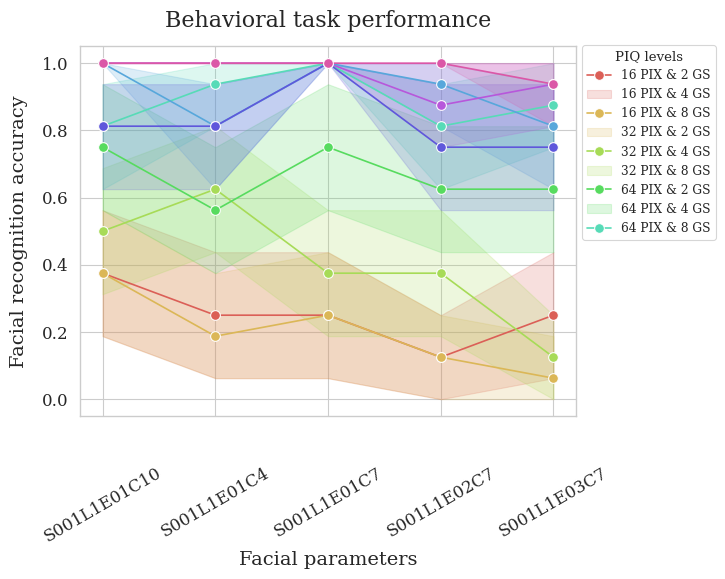

In [24]:
# Draw accuracy plots based on pars
processed_human_df_T = processed_human_df_T.sort_values(by='Par')
hue_order = [('16PIX', '2GS'), ('16PIX', '4GS'), ('16PIX', '8GS'),
             ('32PIX', '2GS'), ('32PIX', '4GS'), ('32PIX', '8GS'),
             ('64PIX', '2GS'), ('64PIX', '4GS'), ('64PIX', '8GS')]

sns.lineplot(x='Par', y='Mean', data=processed_human_df_T, err_style='band', ci=90, palette=sns.color_palette('hls', 9), marker='o', markersize=7,
             hue=processed_human_df_T[['PIX', 'GS']].apply(tuple, axis=1),
             hue_order=hue_order)
plt.xticks(rotation=30, y=-0.1)
plt.yticks(np.arange(0.2, 1.1, 0.2))
plt.xlabel('Facial parameters')
plt.ylabel('Facial recognition accuracy', labelpad=10)
plt.title('Behavioral task performance', y=1.03)
plt.legend(title='PIQ levels', bbox_to_anchor=(1, 1.02),
           labels=['16 PIX & 2 GS', '16 PIX & 4 GS', '16 PIX & 8 GS',
                   '32 PIX & 2 GS', '32 PIX & 4 GS', '32 PIX & 8 GS',
                   '64 PIX & 2 GS', '64 PIX & 4 GS', '64 PIX & 8 GS'])
plt.show()

sns.lineplot(x='Par', y='Mode', data=processed_human_df_T, err_style='band', ci=90, palette=sns.color_palette('hls', 9), marker='o', markersize=7,
             hue=processed_human_df_T[['PIX', 'GS']].apply(tuple, axis=1),
             hue_order=hue_order)
plt.xticks(rotation=30, y=-0.1)
plt.yticks(np.arange(0.0, 1.1, 0.2))
plt.xlabel('Facial parameters', y=1.5)
plt.ylabel('Facial recognition accuracy', labelpad=10)
plt.title('Behavioral task performance', y=1.03)
plt.legend(title='PIQ levels', bbox_to_anchor=(1, 1.02),
           labels=['16 PIX & 2 GS', '16 PIX & 4 GS', '16 PIX & 8 GS',
                   '32 PIX & 2 GS', '32 PIX & 4 GS', '32 PIX & 8 GS',
                   '64 PIX & 2 GS', '64 PIX & 4 GS', '64 PIX & 8 GS'])
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

S001L1E01C10 v.s. S001L1E01C4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.056e+04
S001L1E01C4 v.s. S001L1E01C7: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=9.372e+03
S001L1E01C7 v.s. S001L1E02C7: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.905e-01 U_stat=1.191e+04
S001L1E02C7 v.s. S001L1E03C7: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.130e+04
S001L1E01C10 v.s. S001L1E01C7: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=9.450e+03
S001L1E01C4 v.s. S001L1E02C7: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.089e+04
S001L1E01C7 v.s. S001L1E03C7: Mann-Whitney-Wilcoxon test two-sided

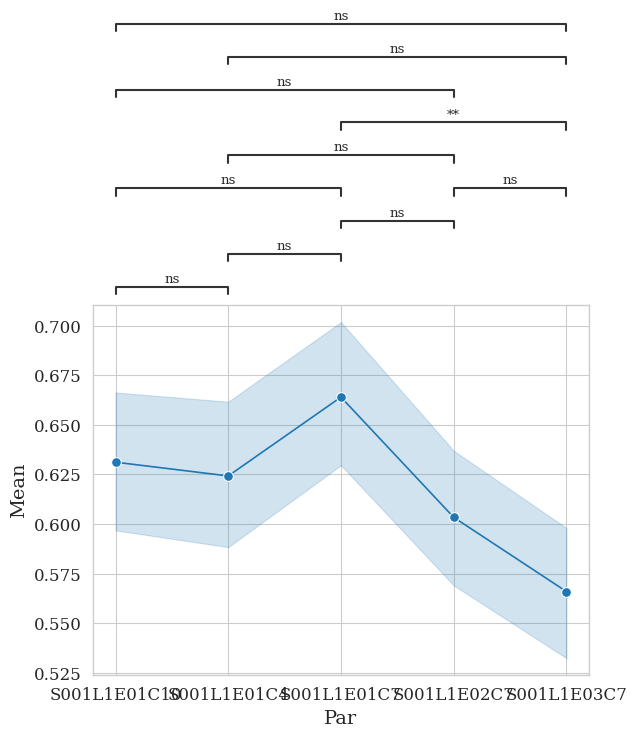

In [144]:
# Check p-values for the averaged pars
box_pairs = [('S001L1E01C10', 'S001L1E01C4'),
             ('S001L1E01C10', 'S001L1E01C7'),
             ('S001L1E01C10', 'S001L1E02C7'),
             ('S001L1E01C10', 'S001L1E03C7'),
             ('S001L1E01C4', 'S001L1E01C7'),
             ('S001L1E01C4', 'S001L1E02C7'),
             ('S001L1E01C4', 'S001L1E03C7'),
             ('S001L1E01C7', 'S001L1E02C7'),
             ('S001L1E01C7', 'S001L1E03C7'),
             ('S001L1E02C7', 'S001L1E03C7')]

plot = sns.lineplot(x='Par', y='Mean', data=processed_human_df_T, err_style='band', ci=90, palette=sns.color_palette('hls', 9), marker='o', markersize=7)
plot, test_results = add_stat_annotation(plot, data=processed_human_df_T, x='Par', y='Mean',
                                         box_pairs=box_pairs, test='Mann-Whitney', text_format='star', loc='outside', verbose=1)
plt.show()

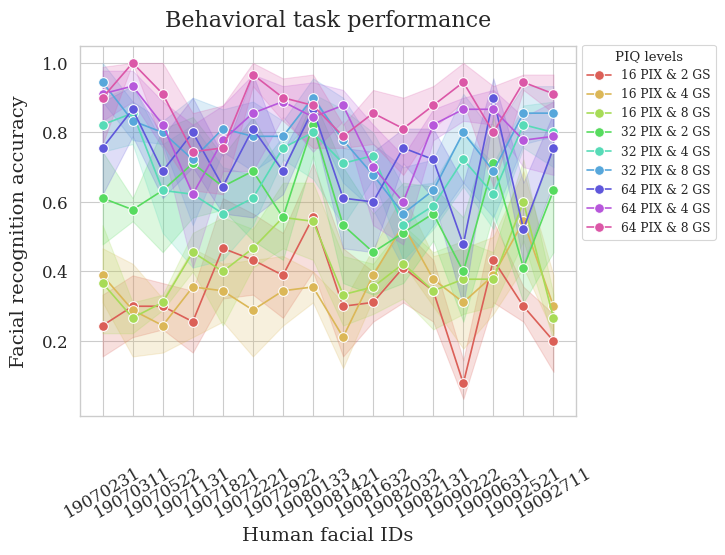

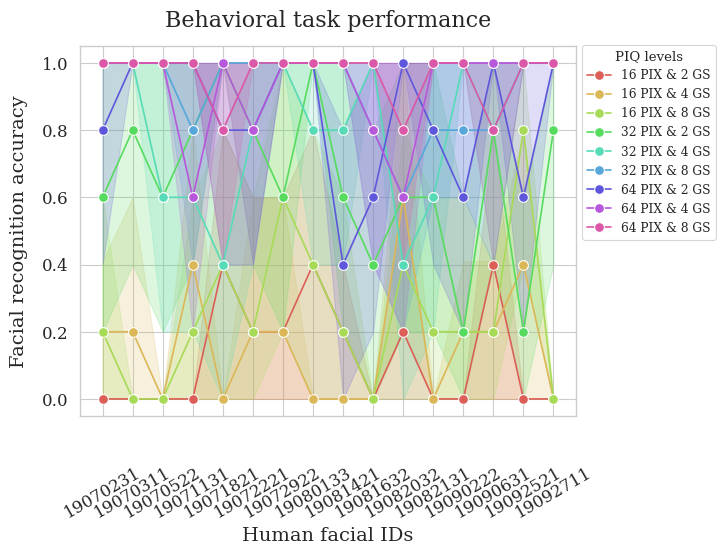

In [145]:
# Draw accuracy plots based on faces
processed_human_df_T = processed_human_df_T.sort_values(by='Face')
hue_order = [('16PIX', '2GS'), ('16PIX', '4GS'), ('16PIX', '8GS'),
             ('32PIX', '2GS'), ('32PIX', '4GS'), ('32PIX', '8GS'),
             ('64PIX', '2GS'), ('64PIX', '4GS'), ('64PIX', '8GS')]

sns.lineplot(x='Face', y='Mean', data=processed_human_df_T, err_style='band', ci=90, palette=sns.color_palette('hls', 9), marker='o', markersize=7,
             hue=processed_human_df_T[['PIX', 'GS']].apply(tuple, axis=1),
             hue_order=hue_order)
plt.xticks(rotation=30, y=-0.1)
plt.yticks(np.arange(0.2, 1.1, 0.2))
plt.xlabel('Human facial IDs')
plt.ylabel('Facial recognition accuracy', labelpad=10)
plt.title('Behavioral task performance', y=1.03)
plt.legend(title='PIQ levels', bbox_to_anchor=(1, 1.02),
           labels=['16 PIX & 2 GS', '16 PIX & 4 GS', '16 PIX & 8 GS',
                   '32 PIX & 2 GS', '32 PIX & 4 GS', '32 PIX & 8 GS',
                   '64 PIX & 2 GS', '64 PIX & 4 GS', '64 PIX & 8 GS'])
plt.show()

sns.lineplot(x='Face', y='Mode', data=processed_human_df_T, err_style='band', ci=90, palette=sns.color_palette('hls', 9), marker='o', markersize=7,
             hue=processed_human_df_T[['PIX', 'GS']].apply(tuple, axis=1),
             hue_order=hue_order)
plt.xticks(rotation=30, y=-0.1)
plt.yticks(np.arange(0.0, 1.1, 0.2))
plt.xlabel('Human facial IDs', y=1.5)
plt.ylabel('Facial recognition accuracy', labelpad=10)
plt.title('Behavioral task performance', y=1.03)
plt.legend(title='PIQ levels', bbox_to_anchor=(1, 1.02),
           labels=['16 PIX & 2 GS', '16 PIX & 4 GS', '16 PIX & 8 GS',
                   '32 PIX & 2 GS', '32 PIX & 4 GS', '32 PIX & 8 GS',
                   '64 PIX & 2 GS', '64 PIX & 4 GS', '64 PIX & 8 GS'])
plt.show()

In [30]:
train_returns_df['Epochs'].astype(int)

0        0
1        1
2       10
3      100
4      101
      ... 
295     95
296     96
297     97
298     98
299     99
Name: Epochs, Length: 300, dtype: int32

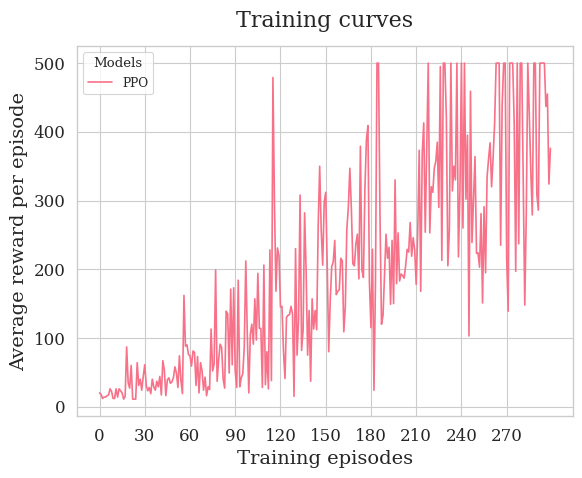

In [31]:
# Check average train returns
train_returns_df = pd.DataFrame()
for (i, file_path) in enumerate(train_returns_files):
    train_returns_df_temp = pd.read_csv(file_path, index_col=0)
    train_returns_df_temp = train_returns_df_temp.transpose().stack().to_frame().reset_index()
    train_returns_df_temp.columns = ['Epochs', 'Timestamps', 'Reward']
    train_returns_df_temp['Models'] = [file_path.split('.')[0].split(f'{slash}')[-1].split('_')[-1]] * train_returns_df_temp.shape[0]
    if i == 0:
        train_returns_df = train_returns_df_temp
    else:
        train_returns_df = pd.concat([train_returns_df, train_returns_df_temp], axis=0)
train_returns_df = train_returns_df.reset_index()
train_returns_df['Epochs'] = train_returns_df['Epochs'].astype(int)

if env_type == 'CartPole-v1':
    train_returns_df = train_returns_df.groupby(['Epochs', 'Models']).agg('sum').reset_index()
sns.lineplot(x='Epochs', y='Reward', data=train_returns_df, err_style='band', ci=90, palette='husl', hue='Models')
plt.xticks(range(0, train_returns_df['Epochs'].max() + 1, (train_returns_df['Epochs'].max() + 1) // 10))
plt.xlabel('Training episodes')
plt.ylabel('Average reward per episode')
plt.title('Training curves', y=1.03)
plt.show()

TypeError: 'float' object cannot be interpreted as an integer

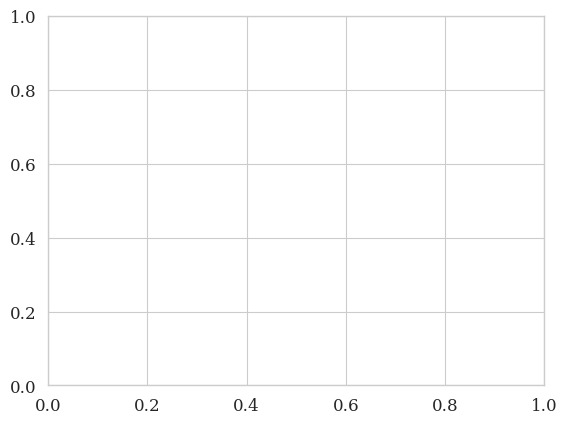

In [38]:
# Check average test returns
test_returns_df = pd.DataFrame()
for (i, file_path) in enumerate(test_returns_files):
    test_returns_df_temp = pd.read_csv(file_path, index_col=0)
    test_returns_df_temp = test_returns_df_temp.transpose().stack().to_frame().reset_index()
    test_returns_df_temp.columns = ['Epochs', 'Timestamps', 'Reward']
    test_returns_df_temp['Models'] = [file_path.split('.')[0].split(f'{slash}')[-1].split('_')[-1]] * test_returns_df_temp.shape[0]
    if i == 0:
        test_returns_df = test_returns_df_temp
    else:
        test_returns_df = pd.concat([test_returns_df, test_returns_df_temp], axis=0)
test_returns_df = test_returns_df.reset_index()
# test_returns_df['Epochs'] = test_returns_df['Epochs'].astype(int).values // 2
test_returns_df['Epochs'] = test_returns_df['Epochs'].astype(int)

if env_type == 'CartPole-v1':
    test_returns_df = test_returns_df.groupby(['Epochs', 'Models']).agg('sum').reset_index()

sns.lineplot(x='Epochs', y='Reward', data=test_returns_df, err_style='band', ci=90, palette='hls', hue='Models')
plt.xticks(range(0, test_returns_df['Epochs'].max() + 1, (test_returns_df['Epochs'].max() + 1) // 10))
plt.xlabel('Evaluation episodes (with off-policy)')
plt.ylabel('Average accuracy per episode')
plt.title('Evaluation curves', y=1.03)
# plt.xlim([0, 30])
plt.show()

c:\ProgramData\Anaconda3\envs\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


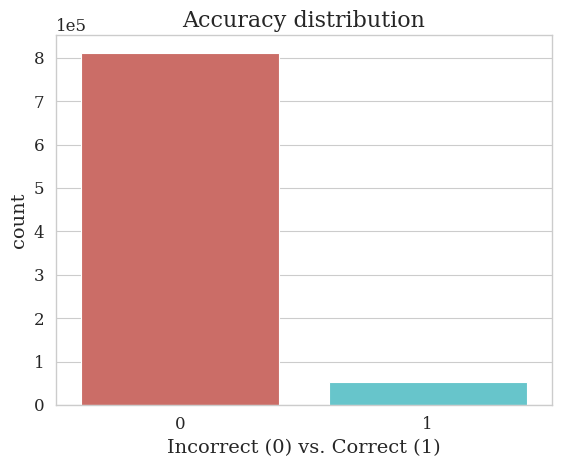

In [241]:
sns.countplot(test_returns_df['Reward'].values, palette='hls')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 4))
plt.xlabel('Incorrect (0) vs. Correct (1)')
plt.title('Accuracy distribution')
plt.show()

In [242]:
# visualize the weights for the best saved model
for file in model_state_dict_files:
    print(file)
    model_dict = torch.load(file)
    for (i, layer_name) in enumerate(model_dict):
        layer_weights = model_dict[layer_name]
        print(layer_name, layer_weights.shape)
    print('')

C:\Users\Na Min An\Desktop\Development\Project\code\outputs\2022-10-21\08-58-16\outputs\DQN.pth
cnn_num_block.0.weight torch.Size([32, 1, 7, 7])
cnn_num_block.0.bias torch.Size([32])
cnn_num_block.3.weight torch.Size([64, 32, 5, 5])
cnn_num_block.3.bias torch.Size([64])
cnn_num_block.6.weight torch.Size([128, 64, 3, 3])
cnn_num_block.6.bias torch.Size([128])
cnn_num_block.9.weight torch.Size([256, 128, 3, 3])
cnn_num_block.9.bias torch.Size([256])
linear_num_block_pi.0.weight torch.Size([128, 30976])
linear_num_block_pi.0.bias torch.Size([128])
linear_num_block_pi.2.weight torch.Size([16, 128])
linear_num_block_pi.2.bias torch.Size([16])

C:\Users\Na Min An\Desktop\Development\Project\code\outputs\2022-10-21\13-24-22\outputs\PPO.pth
cnn_num_block.0.weight torch.Size([32, 1, 7, 7])
cnn_num_block.0.bias torch.Size([32])
cnn_num_block.3.weight torch.Size([64, 32, 5, 5])
cnn_num_block.3.bias torch.Size([64])
cnn_num_block.6.weight torch.Size([128, 64, 3, 3])
cnn_num_block.6.bias torch.Size